In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import bitfinex
from datetime import datetime
import time



# ML methods
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error


import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from keras.callbacks import LearningRateScheduler
from keras.metrics import RootMeanSquaredError
from sklearn.linear_model import LinearRegression


In [2]:
def fetch_data(start=1640991600000, stop=1651356000000, symbol='btcusd', interval='1D', step=31536000000):
    # Create api instance
    api_v2 = bitfinex.bitfinex_v2.api_v2()

    data = []
    names = ['time', 'open', 'close', 'high', 'low', 'volume']

    if stop > time.time() * 1000: # stop value can't be higher than datetime.now()
        stop = datetime.now()
        stop = time.mktime(stop.timetuple()) * 1000
    if stop - start > step: # if data requested > 365 days
        while start < stop:
            if start + step > stop: # if start + 365 days > stop => stop = now
                end = datetime.now()
                end = time.mktime(end.timetuple()) * 1000
            else:
                end = start + step
            #print(datetime.fromtimestamp(start / 1000), datetime.fromtimestamp(end / 1000))
            res = api_v2.candles(symbol=symbol, interval=interval, start=start, end=end)
            data.extend(res)
            start += step
            time.sleep(1)
    else:
        res = api_v2.candles(symbol=symbol, interval=interval, start=start, end=stop)
        data.extend(res)
    #print(data)

    # Modify data to send back a clean DataFrame
    df = pd.DataFrame(data, columns=names)
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df = df.sort_values(by='time')
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)
    df.rename(columns={'time':'date'}, inplace=True)
    return df

In [3]:
pair = 'btcusd'
interval = '1D'

t_start = datetime(2009, 1, 1, 0, 0)
t_start = time.mktime(t_start.timetuple()) * 1000

t_stop = datetime(2023, 1, 1, 0, 0)
t_stop = time.mktime(t_stop.timetuple()) * 1000

In [4]:
df = fetch_data(start=t_start, stop=t_stop, symbol=pair)
df

No keys, only access to public API functions


,date,open,close,high,low,volume
0,2013-03-31,92.500000,93.033000,93.74999,91.00000,3083.079791
1,2013-04-01,93.250000,103.999000,105.90000,92.49999,5224.401313
2,2013-04-02,104.000000,118.229354,118.38670,99.00000,8376.527478
3,2013-04-03,117.958261,134.700000,146.88000,101.51088,12996.245072
4,2013-04-04,134.716560,132.899000,143.00000,119.00000,6981.668305
...,...,...,...,...,...,...
3317,2022-05-07,36041.000000,35506.000000,36170.00000,34854.00000,3781.181837
3318,2022-05-08,35506.000000,34064.000000,35541.00000,33761.00000,6577.706035
3319,2022-05-09,34075.000000,30140.000000,34277.00000,30100.00000,21250.245615
3320,2022-05-10,30136.000000,31072.000000,32687.00000,29833.00000,14172.682208


In [5]:
X_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0,1))

In [61]:
def SplitData(Data, Date, lstm=0, X_scaler=X_scaler, y_scaler=y_scaler):

  index = Data.index[Data['date'] == Date][0]
  X = Data.drop(columns=['date', 'close'], axis=1).to_numpy()
  y = Data['close'].to_numpy()

  if lstm:
    X = X_scaler.fit_transform(np.array(X))
    y = y_scaler.fit_transform(np.array(y).reshape(-1,1))
  
    X_train = X[:index]
    y_train = y[:index]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    X_test = X[index:]
    y_test = y[index:]
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  else:
    X_train = X[:index]
    y_train = y[:index]
    X_test = X[index:]
    y_test = y[index:]

  return X_train, y_train, X_test, y_test

# Linear Regression

In [62]:
date = '2022-02-01'
X_train, y_train, X_test, y_test = SplitData(df, date)

## Test

In [47]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)

Mean Absolute Error - MAE : 411.397760478447


In [51]:
linear_regression_train_predict=linear_regression_model.predict(X_train)
linear_regression_validation_predict=linear_regression_model.predict(X_test)

print("Train data prediction:", linear_regression_train_predict.shape)
print("Validation data prediction:", linear_regression_validation_predict.shape)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, linear_regression_validation_predict)))

Train data prediction: (3222,)
Validation data prediction: (100,)
Mean Absolute Error - MAE : 411.397760478447


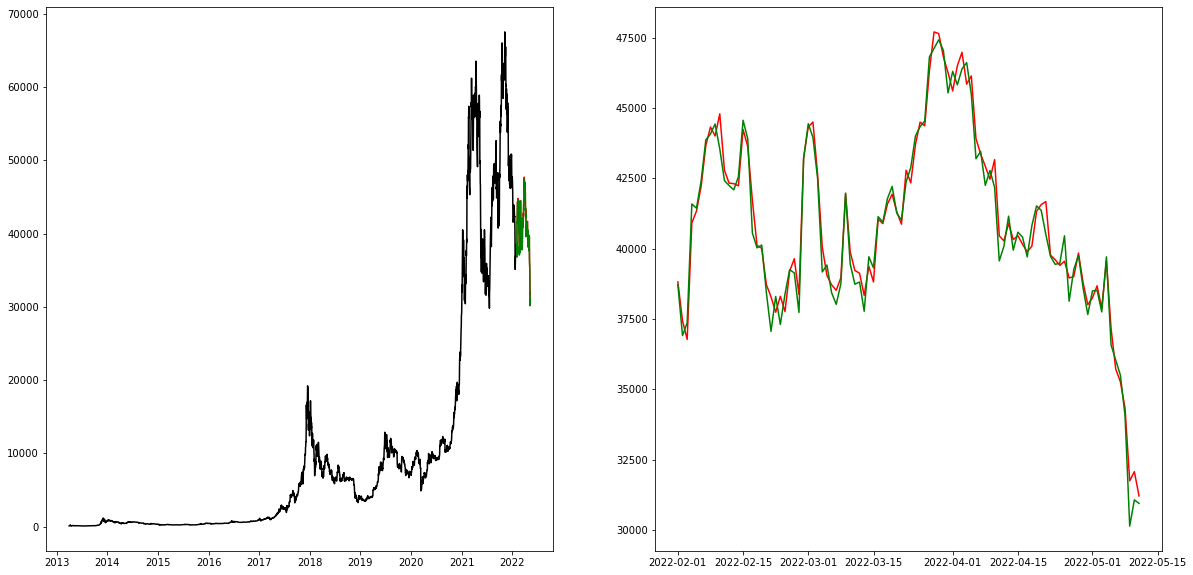

In [49]:
train_size = X_train.shape[0]
f,axs = plt.subplots(1,2,figsize=(20,10))

axs[0].plot(df['date'][:train_size], df['close'][:train_size], color='black')
axs[0].plot(df['date'][train_size:], linear_regression_validation_predict, color='red')
axs[0].plot(df['date'][train_size:], df['close'][train_size:], color='green')
axs[1].plot(df['date'][train_size:], linear_regression_validation_predict, color='red')
axs[1].plot(df['date'][train_size:], df['close'][train_size:], color='green')

## Tune

In [50]:
from sklearn.model_selection import GridSearchCV


lr_gs_model = LinearRegression()

# parameters that we will try to tune
params_lr_gs = {
    'n_jobs': range(1, 1000),
}

param_search = GridSearchCV( estimator=lr_gs_model, param_grid=params_lr_gs,
                verbose=1)
                
param_search.fit(X_train, y_train)

best_score = param_search.best_score_
best_params = param_search.best_params_

print(f'Best accuracy: {best_score} was obtained with parameters: {best_params}')

Fitting 5 folds for each of 999 candidates, totalling 4995 fits
Best accuracy: 0.9950222711126285 was obtained with parameters: {'n_jobs': 1}


In [52]:
lr_final_model = LinearRegression(**best_params)
lr_final_model.fit(X_train, y_train)

LinearRegression(n_jobs=1)

In [53]:
lr_final_train_predict=lr_final_model.predict(X_train)
lr_final_validation_predict=lr_final_model.predict(X_test)

print("Train data prediction:", lr_final_train_predict.shape)
print("Validation data prediction:", lr_final_validation_predict.shape)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, lr_final_validation_predict)))

Train data prediction: (3222,)
Validation data prediction: (100,)
Mean Absolute Error - MAE : 411.397760478447


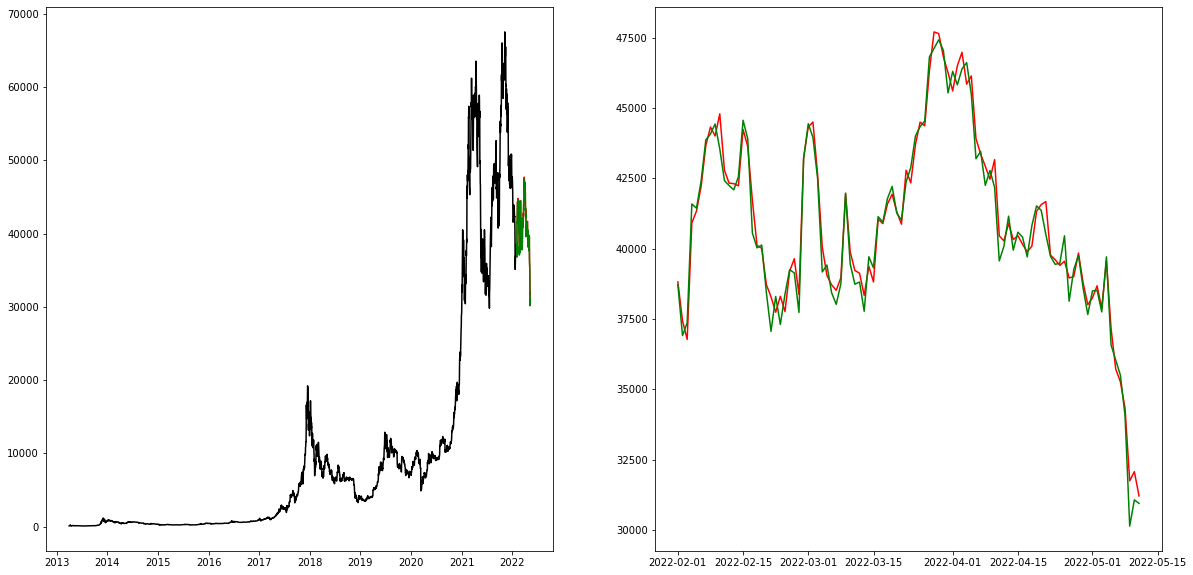

In [55]:
train_size = X_train.shape[0]
f,axs = plt.subplots(1,2,figsize=(20,10))

axs[0].plot(df['date'][:train_size], df['close'][:train_size], color='black')
axs[0].plot(df['date'][train_size:], lr_final_validation_predict, color='red')
axs[0].plot(df['date'][train_size:], df['close'][train_size:], color='green')
axs[1].plot(df['date'][train_size:], lr_final_validation_predict, color='red')
axs[1].plot(df['date'][train_size:], df['close'][train_size:], color='green')

# LSTM

In [63]:
date = '2022-02-01'
X_train, y_train, X_test, y_test = SplitData(df, date, lstm=1)

## Test

In [60]:
def LstmModel():
  model = Sequential([
                    # LSTM(200, input_shape = (4, 1), activation = 'relu', return_sequences = True),
                    # LSTM(200, activation = 'relu'),
                    # Dense(200, activation = 'relu'),
                    # Dense(100, activation = 'relu'),
                    # Dense(50, activation = 'relu'),
                    # Dense(4, activation = 'relu'),
                    # Dense(1, activation = 'relu')
                    LSTM(4, input_shape=(X_train.shape[1], 1)),
                    Dense(1),
                    Dropout(0.2)
                    ])
  return model